# PCA Implementation and Comparison with sklearn

In this notebook, I explore Principal Component Analysis (PCA) using the Olivetti Faces dataset, which is available through the `sklearn` library.

In the first part, I apply PCA using the official `sklearn` implementation to compress one of the images in the dataset into a subspace defined by eigenvectors that explain 90% of the variance. The result is visualized for comparison. The code for this section is taken directly from the official `sklearn` website and is licensed under the BSD 3-Clause License. The full license text, including the copyright notice and disclaimer, is included in the source code provided.

In the second part, I implement a basic, custom version of PCA and apply it to compress the same image into a subspace defined by the eigenvectors that explain 90% of the variance. I then compare the results of this custom (naive) implementation with those obtained using the `sklearn` PCA algorithm.

**License Information:**
The code from the official `sklearn` website, used in the first part of this notebook, is licensed under the BSD 3-Clause License. The full text of the license can be found below.





### Acquiring the Olivetti Faces Dataset

In this section, we load the **Olivetti Faces Dataset** from the `scikit-learn` library. This dataset consists of grayscale images of faces, each with a resolution of 64x64 pixels. It contains a total of 400 images, with 10 different images for each of the 40 unique individuals. This dataset is commonly used for face recognition tasks and dimensionality reduction experiments.

We will be using it to demonstrate the effectiveness of Principal Component Analysis (PCA) in compressing high-dimensional data while retaining as much variance as possible.


In [22]:
import logging

import matplotlib.pyplot as plt
from numpy.random import RandomState

from sklearn import cluster, decomposition
from sklearn.datasets import fetch_olivetti_faces

rng = RandomState(0)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")

faces, _ = fetch_olivetti_faces(return_X_y=True, shuffle=True, random_state=rng)
n_samples, n_features = faces.shape

# Global centering (focus on one feature, centering all samples)
faces_centered = faces - faces.mean(axis=0)

# Local centering (focus on one sample, centering all features)
local_mean = faces_centered.mean(axis=1).reshape(n_samples, -1)
faces_centered -= local_mean

print("Dataset consists of %d faces" % n_samples)

Dataset consists of 400 faces


## Visualizing the Centered Faces

In this section, we visualize a subset of the **centered faces** from the Olivetti dataset. After centering the dataset (both globally and locally as explained earlier), we plot a few examples to see how the centering process has transformed the original images.

The following code defines a helper function `plot_gallery` that helps in visualizing these centered faces. We'll display a grid of images to provide an intuitive understanding of the dataset after preprocessing.




In [23]:
n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)


def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap=plt.cm.gray):
    fig, axs = plt.subplots(
        nrows=n_row,
        ncols=n_col,
        figsize=(2.0 * n_col, 2.3 * n_row),
        facecolor="white",
        constrained_layout=True,
    )
    fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.02, hspace=0, wspace=0)
    fig.set_edgecolor("black")
    fig.suptitle(title, size=16)
    for ax, vec in zip(axs.flat, images):
        vmax = max(vec.max(), -vec.min())
        im = ax.imshow(
            vec.reshape(image_shape),
            cmap=cmap,
            interpolation="nearest",
            vmin=-vmax,
            vmax=vmax,
        )
        ax.axis("off")

    fig.colorbar(im, ax=axs, orientation="horizontal", shrink=0.99, aspect=40, pad=0.01)
    plt.savefig('FaceGrid.jpg')
    plt.show()

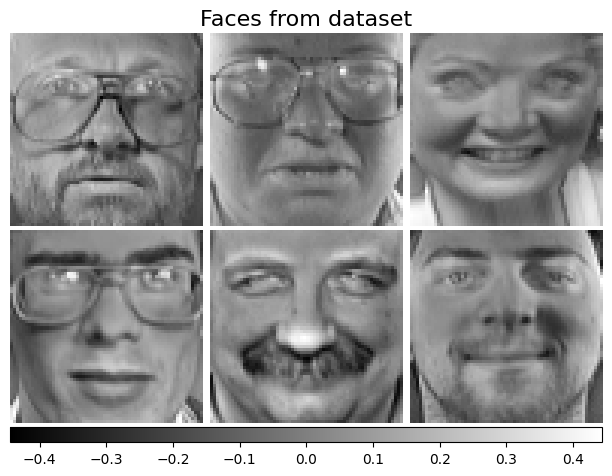

In [24]:
plot_gallery("Faces from dataset", faces_centered[:n_components])

## Initialization of the PCA estimator and calculation of the PCA components



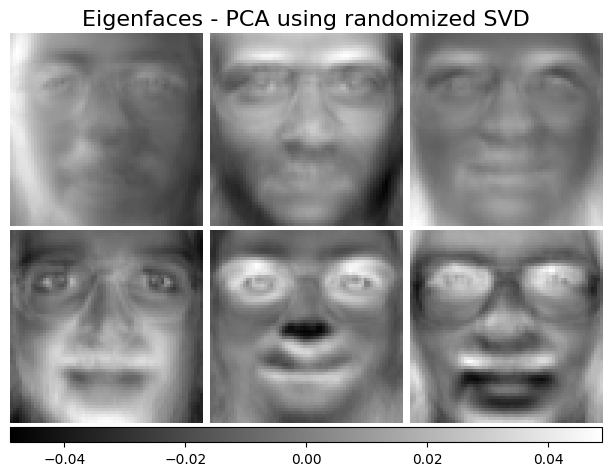

In [25]:
pca_estimator = decomposition.PCA(
    n_components=n_components, svd_solver="randomized", whiten=True
)
pca_estimator.fit(faces_centered)
plot_gallery(
    "Eigenfaces - PCA using randomized SVD", pca_estimator.components_[:n_components]
)

### Projection of one image onto the componets that explain 90% of the variance



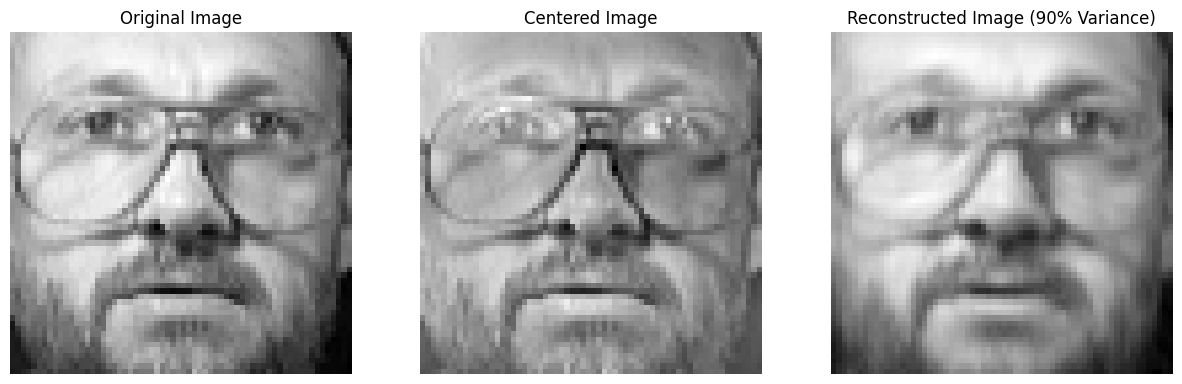

In [26]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'faces_centered' is your centered data (mean subtracted)
# and 'faces' is the original dataset (not centered)

# Step 1: Fit PCA to the centered data
pca_estimator = PCA(svd_solver="randomized", whiten=True)
pca_estimator.fit(faces_centered)

# Step 2: Calculate the cumulative explained variance
explained_variance_ratio = np.cumsum(pca_estimator.explained_variance_ratio_)

# Step 3: Find the number of components that explain at least 90% of the variance
n_components_90 = np.argmax(explained_variance_ratio >= 0.90) + 1

# Step 4: Create a PCA model with the number of components that explain 90% of the variance
pca_estimator_90 = PCA(n_components=n_components_90, svd_solver="randomized", whiten=True)
pca_estimator_90.fit(faces_centered)

# Step 5: Choose an image to project (e.g., index 0)
image_index = 0
original_image = faces[image_index]  # Original image
image_centered = faces_centered[image_index]  # Centered image

# Step 6: Project the image onto the PCA components that explain 90% of the variance
projection = pca_estimator_90.transform([image_centered])  # Project the single image

# Step 7: Reconstruct the image from the projection
reconstructed_image = pca_estimator_90.inverse_transform(projection)


# Step 8 Add back the local mean that was subtracted during centering
reconstructed_image += local_mean[image_index]

# Step 9 Add back the global mean that was subtracted during initial centering
reconstructed_image += faces.mean(axis=0)


# Step 8: Visualize the original, centered, and reconstructed images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the original image
axes[0].imshow(original_image.reshape(64, 64), cmap='gray')
axes[0].axis('off')
axes[0].set_title('Original Image')

# Plot the centered image (original image minus the mean)
axes[1].imshow(image_centered.reshape(64, 64), cmap='gray')
axes[1].axis('off')
axes[1].set_title('Centered Image')

# Plot the reconstructed image from the PCA projection
axes[2].imshow(reconstructed_image.reshape(64, 64), cmap='gray')
axes[2].axis('off')
axes[2].set_title(f'Reconstructed Image (90% Variance)')

plt.savefig('Compressed Image 1')
plt.show()


#Optional I want to be sure to have the same image even in the second part of the notebook
# In addition I want to save the reconstructed image from this first part to compare it the other reconstructed image


test_image = original_image
test_image_centered = image_centered
reconstructed_image_1 = reconstructed_image



## Naive implementation of the PCA by using just numpy:


In the following block I calculate the eigenvalues of the covariance matrix
and I find the range of the eigenvalues that explain 90% of the variance



In [27]:
from sklearn.datasets import fetch_olivetti_faces
import numpy as np
import matplotlib.pyplot as plt

# Load the Olivetti faces dataset
data = fetch_olivetti_faces()
images = data.images  # 400 images of 64x64 pixels
X = data.data         # Flattened images (400, 4096)

# Step 1: Calculate the covariance matrix
# Mean center the data
X_centered = X - np.mean(X, axis=0)

# Compute the covariance matrix
cov_matrix = np.cov(X_centered, rowvar=False)

# Step 2: Perform eigendecomposition
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

# Sort eigenvalues and corresponding eigenvectors in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

# Step 3: Find the number of components to explain 90% variance
total_variance = np.sum(eigenvalues)
variance_explained = np.cumsum(eigenvalues) / total_variance
num_components_90 = np.searchsorted(variance_explained, 0.9) + 1  # +1 as index is zero-based

# Display results
num_components_90, variance_explained[num_components_90 - 1]


(66, 0.9002452434024045)

## Projecting and Visualizing Some of the Calculated Eigenfaces



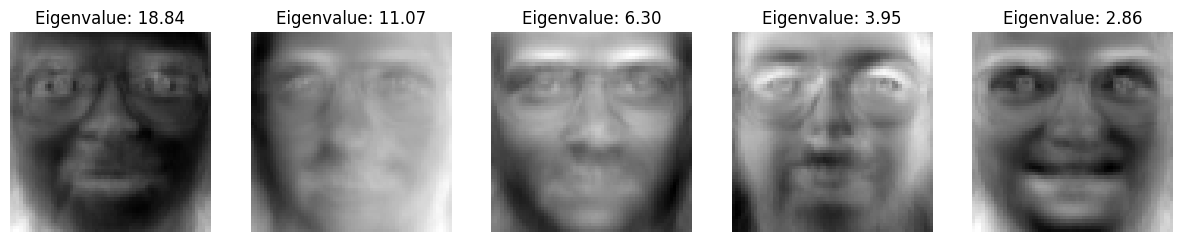

In [28]:
from sklearn.datasets import fetch_olivetti_faces
import numpy as np
import matplotlib.pyplot as plt

# Load the Olivetti faces dataset
data = fetch_olivetti_faces()
images = data.images  # 400 images of 64x64 pixels
X = data.data         # Flattened images (400, 4096)

# Step 1: Calculate the covariance matrix
# Mean center the data
X_centered = X - np.mean(X, axis=0)

# Compute the covariance matrix
cov_matrix = np.cov(X_centered, rowvar=False)

# Step 2: Perform eigendecomposition
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

# Sort eigenvalues and corresponding eigenvectors in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

# Plot the first few eigenfaces corresponding to the top eigenvalues
num_eigenfaces = 5  # Display the first 5 eigenfaces

fig, axes = plt.subplots(1, num_eigenfaces, figsize=(15, 5))

for i in range(num_eigenfaces):
    # Reshape the eigenvector to the original image shape (64x64)
    eigenface = eigenvectors[:, i].reshape(images[0].shape)

    # Plot each eigenface
    axes[i].imshow(eigenface, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'Eigenvalue: {eigenvalues[i]:.2f}')
plt.savefig('Eigenfaces2.jpg')
plt.show()



## Compressing an Image to the Space that Explains 90% of the Variance



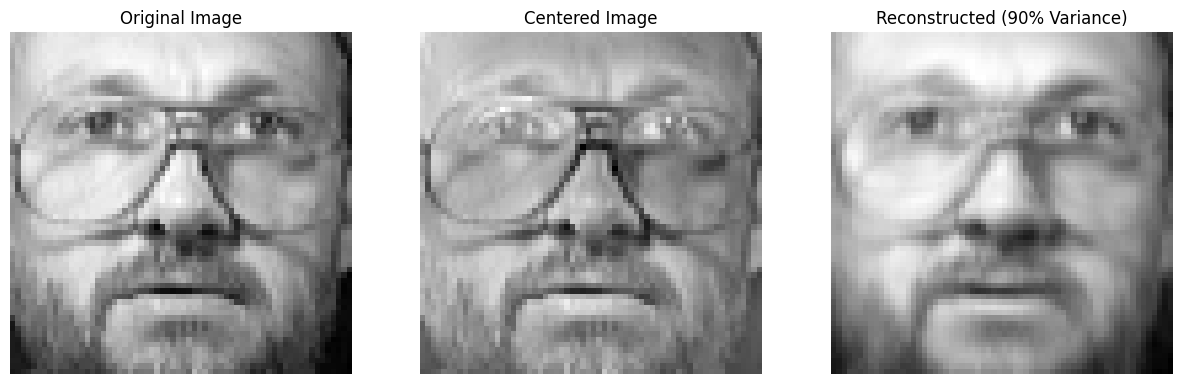

In [29]:
from sklearn.datasets import fetch_olivetti_faces
import numpy as np
import matplotlib.pyplot as plt

# Load the Olivetti faces dataset
data = fetch_olivetti_faces()
images = data.images  # 400 images of 64x64 pixels
X = data.data         # Flattened images (400, 4096)

# Step 1: Calculate the covariance matrix
X_centered = X - np.mean(X, axis=0)
cov_matrix = np.cov(X_centered, rowvar=False)

# Step 2: Perform eigendecomposition
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

# Sort eigenvalues and corresponding eigenvectors in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

# Step 3: Calculate the cumulative variance explained by the eigenvalues
explained_variance = eigenvalues / np.sum(eigenvalues)
cumulative_explained_variance = np.cumsum(explained_variance)

# Step 4: Find the number of eigenvectors that explain 90% of the variance
num_components_90 = np.argmax(cumulative_explained_variance >= 0.90) + 1

# Step 5: Choose an image to project
# I take the image from the first part of the notebook
original_image = test_image

# Step 6: Center the image (subtract the mean of the dataset)
image_centered = original_image - np.mean(X, axis=0)

# Step 7: Project the centered image onto the eigenfaces (with the top components explaining 90% of variance)
eigenvectors_90 = eigenvectors[:, :num_components_90]
projection_90 = eigenvectors_90.T.dot(image_centered)

# Step 8: Reconstruct the image from the projection
reconstructed_image_90 = np.mean(X, axis=0) + eigenvectors_90.dot(projection_90)

# Step 9: Reshape the images to 64x64 and display them
original_image_reshaped = original_image.reshape(images[0].shape)
reconstructed_image_90_reshaped = reconstructed_image_90.reshape(images[0].shape)

# Plotting the images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the original image
axes[0].imshow(original_image_reshaped, cmap='gray')
axes[0].axis('off')
axes[0].set_title('Original Image')

# Plot the centered image (original image minus the mean)
axes[1].imshow(image_centered.reshape(images[0].shape), cmap='gray')
axes[1].axis('off')
axes[1].set_title('Centered Image')

# Plot the reconstructed image from the projection onto the 90% variance subspace
axes[2].imshow(reconstructed_image_90_reshaped, cmap='gray')
axes[2].axis('off')
axes[2].set_title(f'Reconstructed (90% Variance)')

plt.savefig('CompressedImage2.jpg')
plt.show()


## Here Are the Two Reconstructions Side by Side!



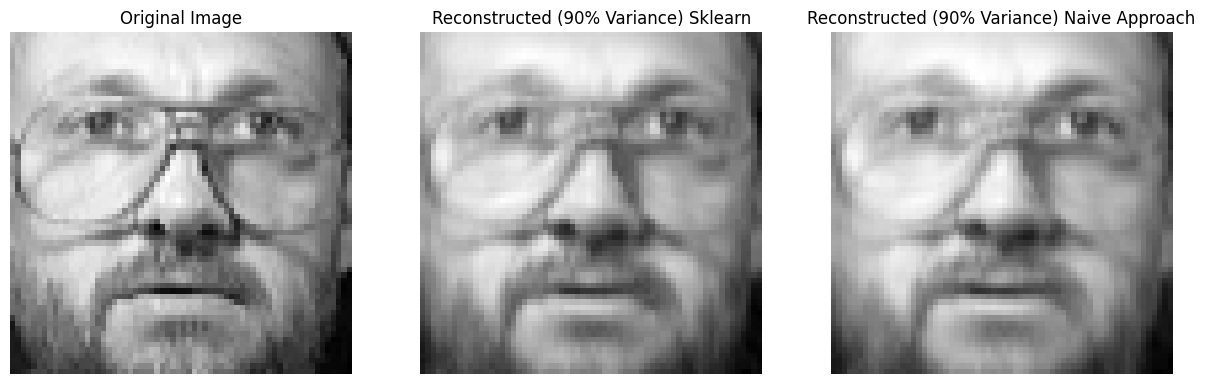

In [30]:
test_image = test_image.reshape(images[0].shape)
reconstructed_image_1 = reconstructed_image_1.reshape(images[0].shape)

# Plotting the images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the original image
axes[0].imshow(test_image, cmap='gray')
axes[0].axis('off')
axes[0].set_title('Original Image')

# Plot the original image
axes[1].imshow(reconstructed_image_1, cmap='gray')
axes[1].axis('off')
axes[1].set_title('Reconstructed (90% Variance) Sklearn')

# Plot the reconstructed image from the projection onto the 90% variance subspace
axes[2].imshow(reconstructed_image_90_reshaped, cmap='gray')
axes[2].axis('off')
axes[2].set_title(f'Reconstructed (90% Variance) Naive Approach')

plt.savefig('Comparison.jpg')
plt.show()

# Conclusion

I would say that even the Naive Approach delivers a satisfying result. This outcome was achieved simply by understanding the fundamental linear algebra concepts behind PCA.


BSD 3-Clause License

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this list of conditions, and the following disclaimer.
2. Redistributions in binary form must reproduce the above copyright notice, this list of conditions, and the following disclaimer in the documentation and/or other materials provided with the distribution.
3. Neither the name of the <organization> nor the names of its contributors may be used to endorse or promote products derived from this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
